# Learn how to perform regression

We're going to train a neural network that knows how to perform inference in robust linear regression models.
The network will have as input: 

* $x$, a vector of input values, and 
* $y$, a vector of output values.

It will learn how to perform posterior inference for the parameter vector $w$, in a linear regression model.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import sys, inspect
sys.path.insert(0, '..')

%matplotlib inline
import pymc
import matplotlib.pyplot as plt

from learn_smc_proposals import cde
from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

First step: let's define linear regression as a PyMC model. This model has:

* an intercept term, a linear term, and a quadratic term
* Laplace distribution (double exponential) priors on the weights
* T-distributed (heavy-tailed) likelihoods


In [2]:
num_points = 10 # number of points in the synthetic dataset we train on

def robust_regression(x, t, sigma_0=np.array([10.0, 1.0, .1]), epsilon=1.0):
    """ X: input (NxD matrix)
        t: output (N vector)
        sigma_0: prior std hyperparameter for weights
        epsilon: std hyperparameter for output noise """
    
    if x is not None:
        N, D = x.shape
        assert D == 1
    else:
        N = num_points
        D = 1
    
    # assume our input variable is bounded by some constant
    const = 10.0
    x = pymc.Uniform('x', lower=-const, upper=const, value=x, size=(N, D), observed=(x is not None))
    
    # create design matrix (add intercept)
    @pymc.deterministic(plot=False)
    def X(x=x, N=N):
        return np.hstack((np.ones((N,1)), x, x**2))

    w = pymc.Laplace('w', mu=np.zeros((D+2,)), tau=sigma_0**(-1.0))
    
    @pymc.deterministic(plot=False, trace=False)
    def mu(X=X, w=w):
        return np.dot(X, w)
    
    y = pymc.NoncentralT('y', mu=mu, lam=epsilon**(-2.0), nu=4, value=t, observed=(t is not None))

    return locals()

## Instantiate the generative model

We'll define `M_train`, a PyMC model which doesn't have any data attached.

We can use `M_train.draw_from_prior()` to construct synthetic datasets to use for training.

In [3]:
M_train = pymc.Model(robust_regression(None, None))

def get_observed(model):
    return np.atleast_2d(np.concatenate((model.x.value.ravel(), model.y.value.ravel())))

def get_latent(model):
    return np.atleast_2d(model.w.value)

def generate_synthetic(model, size=100):
    observed, latent = get_observed(model), get_latent(model)
    for i in range(int(size)-1):
        model.draw_from_prior()
        observed = np.vstack((observed, get_observed(model)))
        latent = np.vstack((latent, get_latent(model)))
    return observed, latent

gen_data = lambda num_samples: generate_synthetic(M_train, num_samples)
example_minibatch = gen_data(100)

## Define a network which will invert this model

Each of the 3 dimensions of the latent space will be modeled by a mixture of Gaussians.

In [4]:
observed_dim = num_points*2
latent_dim = 3
hidden_units = 300
hidden_layers = 2
mixture_components = 3
dist_est = cde.ConditionalRealValueMADE(observed_dim, latent_dim, hidden_units, hidden_layers, mixture_components)
if torch.cuda.is_available():
    dist_est.cuda()

dist_est

ConditionalRealValueMADE(
  (relu): ReLU()
  (softplus): Softplus(beta=1, threshold=20)
  (layers): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=300)
    (1): MaskedLinear(in_features=300, out_features=300)
  )
  (skip_alpha): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (skip_mu): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (skip_sigma): ModuleList(
    (0): MaskedLinear(in_features=23, out_features=3)
    (1): MaskedLinear(in_features=23, out_features=3)
    (2): MaskedLinear(in_features=23, out_features=3)
  )
  (alpha): ModuleList(
    (0): MaskedLinear(in_features=300, out_features=3)
    (1): MaskedLinear(in_features=300, out_features=3)
    (2): MaskedLinear(in_features=300, out_features=3)
  )


### We can use our network to sample and to compute logpdfs.

The primary interface is through `.sample(parents)`, and `.logpdf(parents, latent)`.

Both of these expect pytorch tensors as inputs.

In [5]:
example_parents = Variable(torch.FloatTensor(example_minibatch[0][:5]))
example_latents = Variable(torch.FloatTensor(example_minibatch[1][:5]))
if torch.cuda.is_available():
    example_parents = example_parents.cuda()
    example_latents = example_latents.cuda()

print("Sampled from p(latent|parents):\n\n", dist_est.sample(example_parents))
print("Evaluate log p(latent|parents):\n\n", dist_est.logpdf(example_parents, example_latents))

Sampled from p(latent|parents):

 Variable containing:
 1.1278  0.7115  0.1369
-0.9326 -0.5540 -0.9076
 0.1564  1.7148 -1.2567
 0.0467 -0.2295  0.5941
 0.8542 -0.5856 -0.2505
[torch.cuda.FloatTensor of size 5x3 (GPU 0)]

Evaluate log p(latent|parents):

 Variable containing:
-238.1744
  -8.1857
-207.2414
  -2.6052
 -11.4560
[torch.cuda.FloatTensor of size 5x1 (GPU 0)]



## Optimize network parameters

The `training_epoch` code samples a synthetic dataset, and performs minibatch updates on it for a while. Optionally, it can decide when to stop by examining synthetic validation data.

In [12]:
def _iterate_minibatches(inputs, outputs, batchsize):
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield Variable(torch.FloatTensor(inputs[excerpt])), Variable(torch.FloatTensor(outputs[excerpt]))

def training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, max_local_iters=10, misstep_tolerance=0, verbose=False):
    """ Training function for fitting density estimator to simulator output """
    # Train
    synthetic_ins, synthetic_outs = gen_data(dataset_size)
    validation_size = dataset_size/10
    validation_ins, validation_outs = [Variable(torch.FloatTensor(t)) for t in gen_data(validation_size)]
    missteps = 0
    num_batches = float(dataset_size)/batch_size
    
    USE_GPU = dist_est.parameters().__next__().is_cuda
    if USE_GPU:
        validation_ins = validation_ins.cuda()
        validation_outs = validation_outs.cuda()
    
    validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
    for local_iter in range(max_local_iters):
        
        train_err = 0 
        for inputs, outputs in _iterate_minibatches(synthetic_ins, synthetic_outs, batch_size):
            optimizer.zero_grad()
            if USE_GPU:
                loss = -torch.mean(dist_est.logpdf(inputs.cuda(), outputs.cuda()))
            else:
                loss = -torch.mean(dist_est.logpdf(inputs, outputs))
            loss.backward()
            optimizer.step()
            train_err += loss.data[0]/num_batches
            
        next_validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
        if next_validation_err > validation_err:
            missteps += 1
        validation_err = next_validation_err
        if missteps > misstep_tolerance:
            break

    if verbose:
        print(train_err, validation_err, "(", local_iter+1, ")")
        
    return train_err, validation_err, local_iter+1

In [13]:
optimizer = torch.optim.Adam(dist_est.parameters())
trace_train = []
trace_validation = []
trace_local_iters = []

In [14]:
num_iterations = 500
dataset_size = 2500
batch_size = 250

for i in range(num_iterations):
    verbose = (i+1) % 25 == 0
    if verbose:
        print("["+str(1+len(trace_train))+"]")
    t,v,l = training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, verbose=verbose)
    trace_train.append(t)
    trace_validation.append(v)
    trace_local_iters.append(l)

[25]
1.2986946105957031 1.79833984375 ( 4 )
[50]
1.2272505402565004 1.390592098236084 ( 2 )
[75]
1.0292659878730774 1.184126377105713 ( 4 )
[100]
0.6843055337667465 1.0143804550170898 ( 3 )
[125]
0.6206384837627411 1.0209293365478516 ( 3 )
[150]
0.5408380597829819 0.5486330389976501 ( 2 )
[175]
0.2658662848174572 0.5773215293884277 ( 2 )
[200]
-0.06444480139762164 0.21266013383865356 ( 2 )
[225]
-0.3469913810491562 0.08779087662696838 ( 3 )
[250]
-0.4175038978457451 -0.15709854662418365 ( 2 )
[275]
-0.6124545805156231 -0.14706434309482574 ( 2 )
[300]
-0.4723949685692787 -0.4155520796775818 ( 1 )
[325]
-0.7163824349641801 -0.7252171635627747 ( 2 )
[350]
-0.7762016490101815 0.0033036493696272373 ( 2 )
[375]
-0.9600115299224854 -0.9346998929977417 ( 2 )
[400]
-1.2468353509902954 -0.906905472278595 ( 3 )
[425]
-0.5737522002309561 -0.3196548521518707 ( 1 )
[450]
-0.8412549734115601 -0.9441866278648376 ( 1 )
[475]
-0.901758223772049 -0.9689907431602478 ( 1 )
[500]
-0.9140142023563385 -0.9363

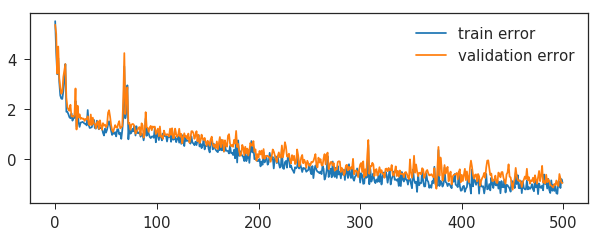

In [15]:
plt.figure(figsize=(10,3.5))
plt.plot(np.array(trace_train))
plt.plot(np.array(trace_validation))
plt.legend(['train error', 'validation error']);

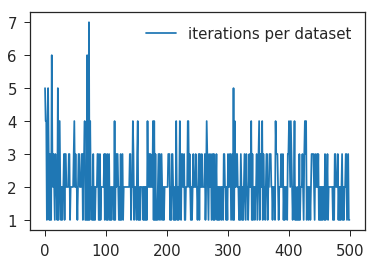

In [22]:
plt.plot(np.array(trace_local_iters))
plt.legend(['iterations per dataset'])

## Define plotting and testing functions

We'll use PyMC's default Metropolis-Hastings as a benchmark, and compare to sampling directly from the learned model, and importance sampling.

In [23]:
def gen_example_pair(model):
    model.draw_from_prior()
    data_x = model.X.value
    data_y = model.y.value
    true_w = model.w.value
    return data_x, data_y, true_w

def estimate_MCMC(data_x, data_y, ns, iters=10000, burn=0.5):
    """ MCMC estimate of weight distribution """
    mcmc_est = pymc.MCMC(robust_regression(data_x[:,1:2], data_y))
    mcmc_est.sample(iters, burn=burn*iters, thin=np.ceil(burn*iters/ns))
    trace_w = mcmc_est.trace('w').gettrace()[:ns]
    return trace_w

def estimate_NN(network, data_x, data_y, ns):
    """ NN proposal density for weights """
    nn_input = Variable(torch.FloatTensor(np.concatenate((data_x[:,1], data_y[:]))))
    print(nn_input.size())
    nn_input = nn_input.unsqueeze(0).repeat(ns,1)
    if network.parameters().__next__().is_cuda:
        nn_input = nn_input.cuda()
    values, log_q = network.propose(nn_input)
    return values.cpu().data.numpy(), log_q.squeeze().cpu().data.numpy()

def sample_prior_proposals(model, ns):
    samples = []
    for n in range(ns):
        model.draw_from_prior()
        samples.append(model.w.value)
    return np.array(samples)

def compare_and_plot(ns=100, alpha=0.05, data_x=None, data_y=None, true_w=None):
    model = pymc.Model(robust_regression(None, None))
    prior_proposals = sample_prior_proposals(model, ns*10)
    if data_x is None:
        data_x, data_y, true_w = gen_example_pair(model)
    mcmc_trace = estimate_MCMC(data_x, data_y, ns)
    nn_proposals, logq = estimate_NN(dist_est, data_x, data_y, ns*10)
    mcmc_mean = mcmc_trace.mean(0)
    nn_mean = nn_proposals.mean(0)
    print()
    print("True (generating) w:", true_w)
    print("MCMC weight mean:", mcmc_mean)
    print("NN weight proposal mean:", nn_mean)
    
    domain = np.linspace(min(data_x[:,1])-2, max(data_x[:,1])+2, 50)
    plt.figure(figsize=(14,3))
    plt.subplot(141)

    plt.plot(domain, mcmc_mean[0] + mcmc_mean[1]*domain + mcmc_mean[2]*domain**2, "b--")
    for i in range(ns):
        plt.plot(domain, mcmc_trace[i,0] + mcmc_trace[i,1]*domain + mcmc_trace[i,2]*domain**2, "b-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.xlim(np.min(domain),np.max(domain))
    limy = plt.ylim()
    plt.legend(["MH posterior"])

    ax = plt.subplot(143)
    plt.plot(domain, nn_mean[0] + nn_mean[1]*domain + nn_mean[2]*domain**2, "r--")
    for i in range(ns):
        plt.plot(domain, nn_proposals[i,0] + nn_proposals[i,1]*domain  + nn_proposals[i,2]*domain**2, "r-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN proposal"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    ax = plt.subplot(142)
    prior_samples_mean = prior_proposals.mean(0)
    prior_proposals = prior_proposals[::10]
    plt.plot(domain, prior_samples_mean[0] + prior_samples_mean[1]*domain + prior_samples_mean[2]*domain**2, "c--")
    for i in range(ns):
        plt.plot(domain, prior_proposals[i,0] + prior_proposals[i,1]*domain  + prior_proposals[i,2]*domain**2, "c-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["Prior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));    
    ax.yaxis.set_ticklabels([])

    # compute NN-IS estimate
    logp = []
    nn_test_model = pymc.Model(robust_regression(data_x[:,1:2], data_y))
    for nnp in nn_proposals:
        nn_test_model.w.value = nnp
        try:
            next_logp = nn_test_model.logp
        except:
            next_logp = -np.Inf
        logp.append(next_logp)
    logp = np.array(logp)
    w = np.exp(logp - logq) / np.sum(np.exp(logp - logq))
    nnis_mean = np.sum(w*nn_proposals.T,1)
    print("NN-IS estimated mean:", nnis_mean)
    print("NN-IS ESS:", 1.0/np.sum(w**2), w.shape[0])
    
    ax = plt.subplot(144)
    plt.plot(domain, nnis_mean[0] + nnis_mean[1]*domain + nnis_mean[2]*domain**2, "g--")
    
    nn_resampled = nn_proposals[systematic_resample(np.log(w))][::10]
    for i in range(ns):
        plt.plot(domain, nn_resampled[i,0] + nn_resampled[i,1]*domain  + nn_resampled[i,2]*domain**2, "g-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN-IS posterior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    plt.tight_layout()

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [-0.17547723  1.38782382  0.1115978 ]
MCMC weight mean: [-0.40669828  1.36257087  0.12037109]
NN weight proposal mean: [ 1.38964307  1.13570523  0.08918093]
NN-IS estimated mean: [-0.10382622  1.37222692  0.11506907]
NN-IS ESS: 43.0550789928 1000


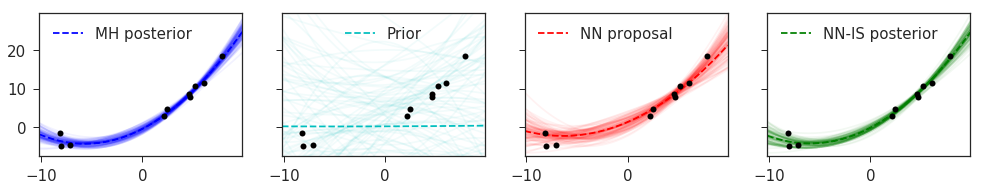

In [24]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [  1.99782389e+01  -4.61731518e-01  -6.03984314e-03]
MCMC weight mean: [  1.95510126e+01  -3.47619709e-01  -1.46932747e-03]
NN weight proposal mean: [  1.94429436e+01  -4.08938318e-01   1.70142092e-02]
NN-IS estimated mean: [  1.92899263e+01  -3.40836446e-01   2.60000851e-03]
NN-IS ESS: 111.005399694 1000


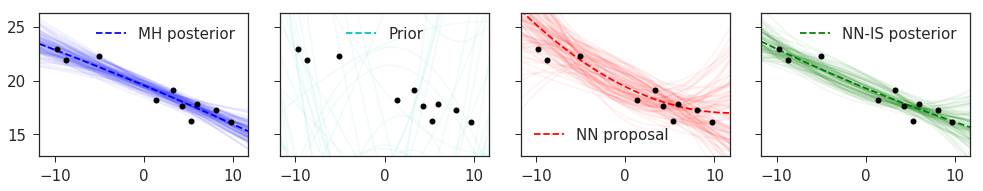

In [25]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [ 8.96484327 -0.13341401  0.11058505]
MCMC weight mean: [ 8.57120411 -0.29239454  0.14412008]
NN weight proposal mean: [ 8.99372387 -0.27211741  0.11583435]
NN-IS estimated mean: [ 8.50331129 -0.30555844  0.14827071]
NN-IS ESS: 303.848945567 1000


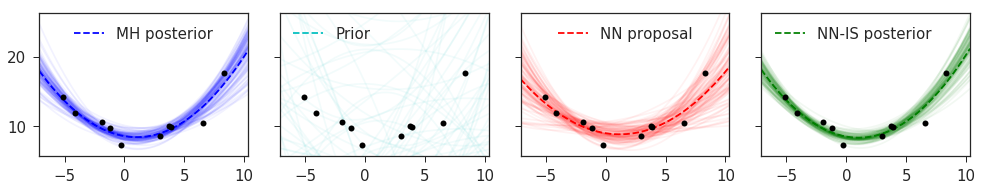

In [26]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [ -1.86312719e+00  -2.11547132e+00  -1.60822014e-03]
MCMC weight mean: [-2.12495811 -2.02779069  0.00886208]
NN weight proposal mean: [ -2.05267954e+00  -2.01273704e+00  -1.05198727e-04]
NN-IS estimated mean: [-2.08870598 -2.02702044  0.00948632]
NN-IS ESS: 160.440199053 1000


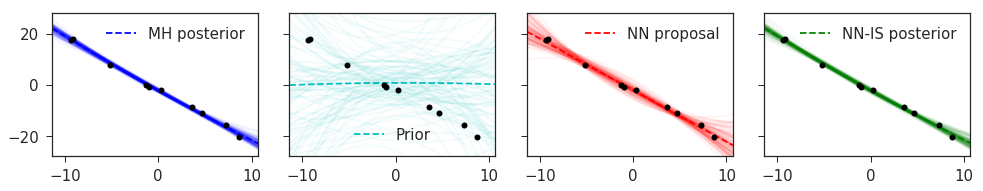

In [27]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.6 sectorch.Size([20])

True (generating) w: [-8.1440439  -0.59542093  0.04014044]
MCMC weight mean: [-7.67228314 -0.50073213  0.03891603]
NN weight proposal mean: [-7.06726694 -0.5682326   0.02171252]
NN-IS estimated mean: [-7.38528611 -0.52177888  0.03233655]
NN-IS ESS: 134.530924792 1000


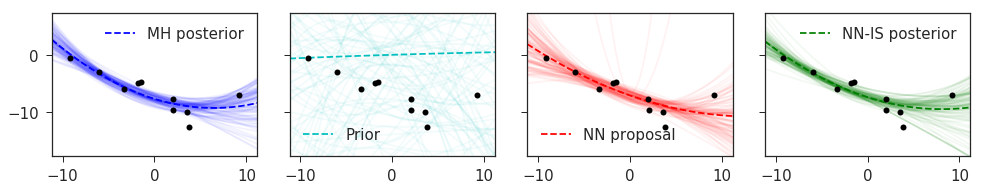

In [28]:
compare_and_plot();